# Objetivo

Criar um modelo preditivo desafiante ao feito usando LightGBM. 

# Abordagem

Aqui o algoritmo usado foi o AutoEncoder. <br>
A ideia é que o Autoencoder recebe as variáveis preditivas, diminui a dimensionalidade e depois aumenta de novo, tentando recriar as variáveis preditivas originais. <br>
O "score" é dado pelo erro entre as variáveis originais e as recriadas, e por isso todas as variáveis foram normalizadas para que a noção de distância não seja enviesada pela grandez das variáveis. <br>
O esperado dessa abordagem é que como o AutoEncoder é treinado usando apenas as transações não fraudulentas, ao aplicarmos o algoritmo em transações fraudulentas ele tenha resultados piores de replicação, aumentando assim o erro. <br>
Por ser um modelo baseado em Redes Neurais, a otimização de hiperparametros se torna ainda mais importante, de froma que usamos o Optuna no código "otimizacao_hiperparametros_optuna_ia_generativa" para tal fim. <br>
O código do Optuna além de fazer a otimização de hiperparametros, também foi dado o desafio de fazer o feature selection. Para entender a eficácia desse Feature selection, comparei esta abordagem com uma abordagem mais tradicional que é a Forward Feature Selection.

# Resultados

O AutoEncoder funcionou como esperado e trouxe separação entre casos fraudulentos e não fraudulentos, porém com resultados inferiores aos obtidos com o LightGBM. <br>
Além disso, o Feature Selection do Optuna trouxe resultados piores que os obtidos pelo Forward Feature Selection.

# Conclusões

Para essa base de dados com estes parâmetros as técnicas clássicas trouxeram melhores resultados. Além disso, o feature selection do Optuna aplicado ao AutoEncoder trouxe piores resultados que o Forward Feature Selection.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/creditcard.csv')
df.columns = df.columns.str.lower()
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Separando as transações legítimas (fraud = 0) e fraudulentas (fraud = 1)
X = df.drop(['time', 'class'], axis=1).copy()
y = df['class'].copy()

# Dividindo em treino e teste
X_train_main, X_test_main, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_main), columns=X_train_main.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_main), columns=X_test_main.columns)

In [6]:
df[X_train_main.columns] = pd.DataFrame(scaler.transform(df[X_train_main.columns]), columns=X_train_main.columns)

In [9]:
X_train_scaled = X_train_scaled.reset_index().drop('index', axis=1)
X_test_scaled = X_test_scaled.reset_index().drop('index', axis=1)

y_train = pd.DataFrame(y_train).reset_index().drop('index', axis=1)['class']
y_test = pd.DataFrame(y_test).reset_index().drop('index', axis=1)['class']

In [10]:
# Calcule o KS
def ks_metric(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    return ks

### Forward feature selection usando a feature importance do LightGBM

In [11]:
feature_importance = ['v4',
 'v14',
 'amount',
 'v17',
 'v12',
 'v7',
 'v10',
 'v8',
 'v26',
 'v3',
 'v19',
 'v16',
 'v2',
 'v22',
 'v21',
 'v25',
 'v13',
 'v6',
 'v23',
 'v20',
 'v5',
 'v24',
 'v28',
 'v15',
 'v27',
 'v11',
 'v18',
 'v9',
 'v1']

In [12]:
results = {}
hora_inicio = datetime.now()
lista = feature_importance[:1]
ks_final = 0
for i in range(1, len(feature_importance)+1):

    lista_desafiante = lista + feature_importance[i:i+1]

    X_train = X_train_scaled[lista_desafiante].copy()
    X_test = X_test_scaled[lista_desafiante].copy()

    # Construindo o Autoencoder
    optimizer = SGD(learning_rate=0.02295420468278658)

    input_dim = X_train.shape[1]  # Número de features
    encoding_dim = 2  # Tamanho da camada latente

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)

    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    # Treinando o Autoencoder
    history = autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0], 
                            epochs=70, 
                            batch_size=32, 
                            shuffle=True, 
                            validation_data=(X_test[y_test == 0], X_test[y_test == 0]), 
                            callbacks=[early_stopping],
                            verbose=0)
    
    # Calculando o erro de reconstrução (MSE) para o conjunto de teste
    X_train_pred = autoencoder.predict(X_train, verbose=0)
    mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

    X_test_pred = autoencoder.predict(X_test, verbose=0)
    mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

    scaler = MinMaxScaler()
    y_train_pred_proba = scaler.fit_transform(mse_train.values.reshape(-1, 1)).ravel()
    y_test_pred_proba = scaler.transform(mse_test.values.reshape(-1, 1)).ravel()

    # Performance do modelo sem idade e score de mercado
    ks_train = ks_metric(y_train, y_train_pred_proba)
    ks_test = ks_metric(y_test, y_test_pred_proba)

    if ks_train > ks_final:
        ks_final = ks_train
        lista = lista_desafiante

    results[i] = {
    'KS Treino': ks_train,
    'KS Teste': ks_test}

    print(f'Feature: {i} | KS Treino: {ks_train:.4f} | KS Teste: {ks_test:.4f} | Tempo (min): {round(((datetime.now() - hora_inicio).seconds/60), 2)}')

final_results_propagation_df = pd.DataFrame(results)
final_results_propagation_df.T

Feature: 1 | KS Treino: 0.8508 | KS Teste: 0.8361 | Tempo (min): 7.35
Feature: 2 | KS Treino: 0.8231 | KS Teste: 0.8251 | Tempo (min): 14.35
Feature: 3 | KS Treino: 0.8598 | KS Teste: 0.8638 | Tempo (min): 22.5
Feature: 4 | KS Treino: 0.8541 | KS Teste: 0.8585 | Tempo (min): 29.68
Feature: 5 | KS Treino: 0.8539 | KS Teste: 0.8624 | Tempo (min): 36.78
Feature: 6 | KS Treino: 0.8522 | KS Teste: 0.8461 | Tempo (min): 43.87
Feature: 7 | KS Treino: 0.8477 | KS Teste: 0.8433 | Tempo (min): 50.92
Feature: 8 | KS Treino: 0.8575 | KS Teste: 0.8641 | Tempo (min): 58.03
Feature: 9 | KS Treino: 0.8561 | KS Teste: 0.8710 | Tempo (min): 65.07
Feature: 10 | KS Treino: 0.8623 | KS Teste: 0.8622 | Tempo (min): 72.13
Feature: 11 | KS Treino: 0.8599 | KS Teste: 0.8519 | Tempo (min): 79.42
Feature: 12 | KS Treino: 0.8570 | KS Teste: 0.8526 | Tempo (min): 86.77
Feature: 13 | KS Treino: 0.8598 | KS Teste: 0.8584 | Tempo (min): 94.07
Feature: 14 | KS Treino: 0.8483 | KS Teste: 0.8522 | Tempo (min): 101.43
Fe

,KS Treino,KS Teste
1,0.850808,0.836150
2,0.823122,0.825146
3,0.859795,0.863765
4,0.854145,0.858510
5,0.853934,0.862351
6,0.852207,0.846082
7,0.847674,0.843313
8,0.857514,0.864065
9,0.856149,0.870973
10,0.862325,0.862228


In [13]:
lista

['v4', 'v14', 'v17', 'v19', 'v13', 'v15']

In [14]:
X_train = X_train_scaled[lista].copy()
X_test = X_test_scaled[lista].copy()

# Construindo o Autoencoder
optimizer = SGD(learning_rate=0.02295420468278658)

input_dim = X_train.shape[1]  # Número de features
encoding_dim = 2  # Tamanho da camada latente

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='sigmoid')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Treinando o Autoencoder
history = autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0], 
                        epochs=70, 
                        batch_size=32, 
                        shuffle=True, 
                        validation_data=(X_test[y_test == 0], X_test[y_test == 0]), 
                        callbacks=[early_stopping],
                        verbose=0)

# Calculando o erro de reconstrução (MSE) para o conjunto de teste
X_train_pred = autoencoder.predict(X_train, verbose=0)
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

X_test_pred = autoencoder.predict(X_test, verbose=0)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

scaler = MinMaxScaler()

df_train = X_train.copy()
df_train['score'] = scaler.fit_transform(mse_train.values.reshape(-1, 1)).ravel()
df_train['target'] = y_train

df_test = X_test.copy()
df_test['score'] = scaler.transform(mse_test.values.reshape(-1, 1)).ravel()
df_test['target'] = y_test

ks_train = ks_metric(df_train['target'], df_train['score'])
ks_test = ks_metric(df_test['target'], df_test['score'])

print(f'KS Treino: {ks_train:.4f} | KS Teste: {ks_test:.4f}')

KS Treino: 0.8651 | KS Teste: 0.8550


In [15]:
df['set'] = 'nulo'
df.loc[X_train.index, 'set'] = 'train'
df.loc[df.iloc[-round(len(X_test)/2):].index, 'set'] = 'test_1'
df.loc[df.iloc[-len(X_test):-round(len(X_test)/2)].index, 'set'] = 'test_2'

In [16]:
df_pred = autoencoder.predict(df[lista], verbose=0)
mse = np.mean(np.power(df[lista] - df_pred, 2), axis=1)

df['score'] = scaler.transform(mse.values.reshape(-1, 1)).ravel()

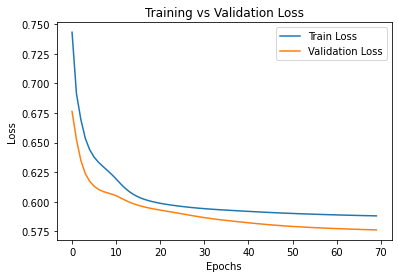

In [17]:
# Acessar a perda de treino e validação no history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotar o gráfico de perda
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

### Teste usando o Feature selection do Optuna

In [18]:
# Feature selection do Optuna
lista_optuna = ['v2', 'v4', 'v5', 'v6', 'v7', 'v10', 'v11', 'v12', 'v14', 'v15', 'v17', 'amount']

In [19]:
X_train = X_train_scaled[lista_optuna].copy()
X_test = X_test_scaled[lista_optuna].copy()

# Construindo o Autoencoder
optimizer = SGD(learning_rate=0.02295420468278658)

input_dim = X_train.shape[1]  # Número de features
encoding_dim = 2  # Tamanho da camada latente

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='sigmoid')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder_optuna = Model(inputs=input_layer, outputs=decoded)

autoencoder_optuna.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Treinando o Autoencoder
history = autoencoder_optuna.fit(X_train[y_train == 0], X_train[y_train == 0], 
                        epochs=70, 
                        batch_size=32, 
                        shuffle=True, 
                        validation_data=(X_test[y_test == 0], X_test[y_test == 0]), 
                        callbacks=[early_stopping],
                        verbose=0)

# Calculando o erro de reconstrução (MSE) para o conjunto de teste
X_train_pred = autoencoder_optuna.predict(X_train, verbose=0)
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

X_test_pred = autoencoder_optuna.predict(X_test, verbose=0)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

scaler_optuna = MinMaxScaler()

df_train = X_train.copy()
df_train['score'] = scaler_optuna.fit_transform(mse_train.values.reshape(-1, 1)).ravel()
df_train['target'] = y_train

df_test = X_test.copy()
df_test['score'] = scaler_optuna.transform(mse_test.values.reshape(-1, 1)).ravel()
df_test['target'] = y_test

ks_train = ks_metric(df_train['target'], df_train['score'])
ks_test = ks_metric(df_test['target'], df_test['score'])

print(f'KS Treino: {ks_train:.4f} | KS Teste: {ks_test:.4f}')

KS Treino: 0.8432 | KS Teste: 0.8395


In [20]:
df_pred = autoencoder_optuna.predict(df[lista_optuna], verbose=0)
mse = np.mean(np.power(df[lista_optuna] - df_pred, 2), axis=1)

df['score_optuna'] = scaler_optuna.transform(mse.values.reshape(-1, 1)).ravel()

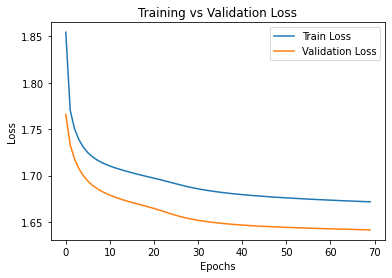

In [21]:
# Acessar a perda de treino e validação no history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotar o gráfico de perda
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

### Resultados dos modelos

In [22]:
bins = [0, 0.025, 0.04, 1]
labels = ['Baixo', 'Médio', 'Alto']

df['score_binned'] = pd.cut(df['score'], bins=bins, labels=labels)

df_grouped = df.groupby(['set', 'score_binned'], observed=False).agg(
    tx_maus=('class', lambda x: x.sum() / x.count()),  
    qtd_casos=('class', 'count'),  
    detection=('class', 'sum')  
)

total_qtd_casos_por_set = df.groupby('set')['class'].count()
df_grouped['perc_casos'] = df_grouped['qtd_casos'] / df_grouped.index.get_level_values('set').map(total_qtd_casos_por_set)

total_maus_por_set = df.groupby('set')['class'].sum()
df_grouped['detection'] = df_grouped['detection'] / df_grouped.index.get_level_values('set').map(total_maus_por_set)

df_grouped

tx_maus  qtd_casos  detection  perc_casos
set    score_binned                                            
test_1 Baixo         0.000247      28393   0.318182    0.996910
       Médio         0.021277         47   0.045455    0.001650
       Alto          0.341463         41   0.636364    0.001440
test_2 Baixo         0.000317      28356   0.169811    0.995611
       Médio         0.047619         63   0.056604    0.002212
       Alto          0.661290         62   0.773585    0.002177
train  Baixo         0.000261     226478   0.141487    0.994000
       Médio         0.021398        701   0.035971    0.003077
       Alto          0.515789        665   0.822542    0.002919

In [32]:
bins_optuna = [0, 0.0025, 0.005, 1]
labels_optuna = ['Baixo', 'Médio', 'Alto']

df['score_optuna_binned'] = pd.cut(df['score_optuna'], bins=bins_optuna, labels=labels_optuna)

df_grouped = df.groupby(['set', 'score_optuna_binned'], observed=False).agg(
    tx_maus=('class', lambda x: x.sum() / x.count()),  
    qtd_casos=('class', 'count'),  
    detection=('class', 'sum')  
)

total_qtd_casos_por_set = df.groupby('set')['class'].count()
df_grouped['perc_casos'] = df_grouped['qtd_casos'] / df_grouped.index.get_level_values('set').map(total_qtd_casos_por_set)

total_maus_por_set = df.groupby('set')['class'].sum()
df_grouped['detection'] = df_grouped['detection'] / df_grouped.index.get_level_values('set').map(total_maus_por_set)

df_grouped

tx_maus  qtd_casos  detection  perc_casos
set    score_optuna_binned                                            
test_1 Baixo                0.000602      28261   0.772727    0.992276
       Médio                0.026316        114   0.136364    0.004003
       Alto                 0.019048        105   0.090909    0.003687
test_2 Baixo                0.000925      28120   0.490566    0.987325
       Médio                0.104167        192   0.377358    0.006741
       Alto                 0.041420        169   0.132075    0.005934
train  Baixo                0.000720     224863   0.388489    0.986912
       Médio                0.058702       1448   0.203837    0.006355
       Alto                 0.110894       1533   0.407674    0.006728